# Requirement 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pricing_environment import PricingEnvironment
from Demand_curve_generator import Demand_curve_generator as demand

from scipy import optimize
from bidding_environment import FirstPriceAuction
from bidding import HedgeAgent, FFMultiplicativePacingAgent
from Competing_bids_generator import generate_bids

import warnings
warnings.filterwarnings("ignore")

## PRICING

In [3]:
# Hedge algorithm for pricing
n_trials = 10

regret_per_trial = []
pseudo_regret_per_trial = []

for seed in range(n_trials):
    np.random.seed(seed)
    T = 10000 # number of days
    epsilon = T**(-0.33)
    K =  int(1/epsilon)# number of actions (see theory for the choice of K)
    n_customers = 100 #this would depend on advertising step
    learning_rate = np.sqrt(np.log(K)/T)


    prices = np.linspace(0,1,K) # 100 actions
    cost = 0.1 #To be chosen

    conversion_rates = []
    random_steeps = np.random.uniform(1,5,T) #generates T parameters for the demand curve 1 for each day (ask if it could be more than one per day)
    conversion_rates = [demand.generate_demand(0,1,steep) for steep in random_steeps]

    reward_function = lambda price, n_sales: (price-cost)*n_sales
    maximum_profit = reward_function(max(prices), n_customers) # the maximum possible reward is selling at the maximum price to every possible customer


    loss_profit_curve = []
    for t in range(T):
        loss_profit_curve.append([(1-(price-cost)*conversion_rates[t](price)) for price in prices])
    loss_profit_curve = np.array(loss_profit_curve)
    summed_losses = np.sum(loss_profit_curve, axis=0)
    best_price_index = np.argmin(summed_losses)
    best_price = prices[best_price_index]
    expected_clairvoyant_losses = loss_profit_curve[:,best_price_index]

    np.random.seed(seed)
    env = PricingEnvironment(conversion_probability=conversion_rates, cost=cost, prices=prices)
    Hedge_agent = HedgeAgent(K, learning_rate)

    agent_losses = np.array([])
    expected_agent_losses = np.array([])


    for t in range(T):
        pi_t = Hedge_agent.pull_arm() ## the agent returns the index!!
        p_t = prices[pi_t] # I get the actual price
        l_t, r_t, d_t = env.round(p_t, n_customers, t)
        Hedge_agent.update(l_t)

        agent_losses = np.append(agent_losses, l_t[pi_t])
        expected_agent_losses = np.append(expected_agent_losses, np.dot(l_t, Hedge_agent.x_t))


    cumulative_regret = np.cumsum(agent_losses-expected_clairvoyant_losses)
    cumulative_pseudo_regret = np.cumsum(expected_agent_losses-expected_clairvoyant_losses)

    regret_per_trial.append(cumulative_regret)
    pseudo_regret_per_trial.append(cumulative_pseudo_regret)

regret_per_trial = np.array(regret_per_trial)
pseudo_regret_per_trial = np.array(pseudo_regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)
average_pseudo_regret = pseudo_regret_per_trial.mean(axis=0)
pseudo_regret_std = pseudo_regret_per_trial.std(axis=0)

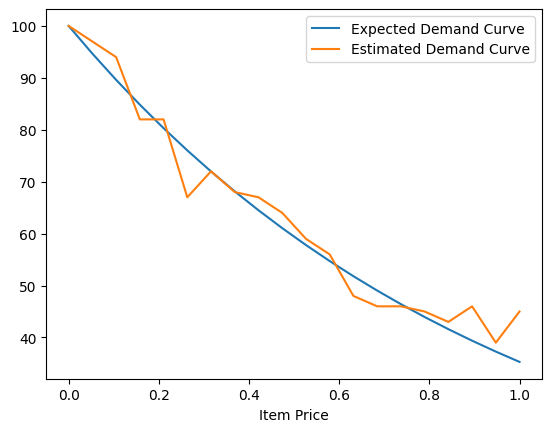

In [4]:
conversion_probability = conversion_rates[0] # I take only the first conversion_probability as an example

expected_demand_curve = n_customers*conversion_probability(prices)

estimated_demand_curve = np.random.binomial(n_customers, conversion_probability(prices))

plt.figure()
plt.plot(prices, expected_demand_curve, label='Expected Demand Curve')
plt.plot(prices, estimated_demand_curve, label='Estimated Demand Curve')
plt.xlabel('Item Price')
plt.legend()
plt.show();

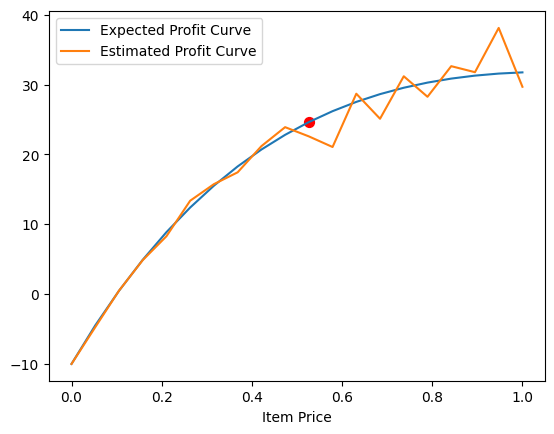

In [5]:
expected_profit_curve = n_customers*conversion_probability(prices)*(prices-cost)

estimated_profit_curve = np.random.binomial(n_customers, conversion_probability(prices))*(prices-cost)

plt.figure()
plt.plot(prices, expected_profit_curve, label='Expected Profit Curve')
plt.plot(prices, estimated_profit_curve, label='Estimated Profit Curve')
plt.scatter(best_price, expected_profit_curve[best_price_index], color='red', s=50)
plt.xlabel('Item Price')
plt.legend()
plt.show();

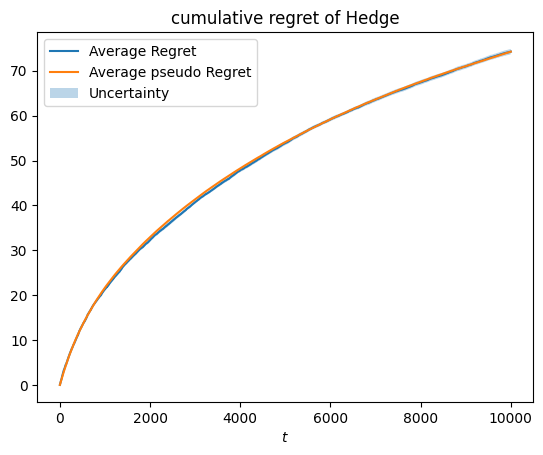

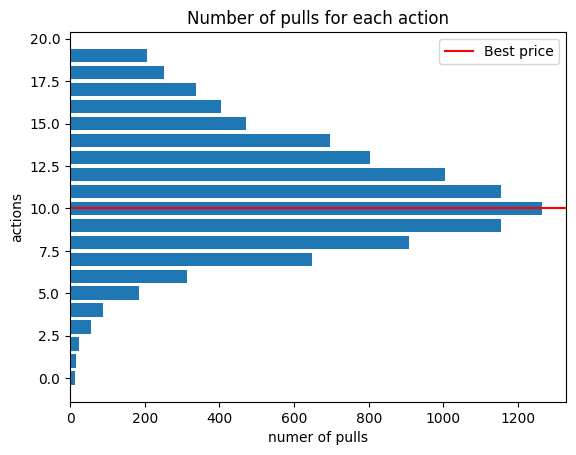

In [6]:
plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.plot(np.arange(T), average_pseudo_regret, label='Average pseudo Regret')
plt.title('cumulative regret of Hedge')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.xlabel('$t$')
plt.legend()
plt.show()

plt.figure()
plt.barh(np.arange(K), Hedge_agent.N_pulls)
plt.axhline(best_price_index, color='red', label='Best price')
plt.ylabel('actions')
plt.xlabel('numer of pulls')
plt.legend()
plt.title('Number of pulls for each action')
plt.show();

## BIDDING

MULTIPLICATIVE PACING

In [7]:
### Adversarial Bidders

n_advertisers = 3
n_users = 15000
Budget = 900
my_valuation = 0.6
rho = Budget/n_users
# non-trivial scenario: competitors sample bids from a uniform with range varying over time

other_bids = np.array([generate_bids(n_advertisers, np.random.normal(0.5, 5), t) for t in range(n_users)]).T

#other_bids = np.random.uniform(0, 1, size = (n_advertisers, n_users))

# I assume that competitors may have a larger budget than mine, but they may
# not deplete it.

m_t = other_bids.max(axis=0)

available_bids = np.linspace(0,1,11)
win_probabilities = np.array([sum(b > m_t)/n_users for b in available_bids])
## Linear Program
c = -(my_valuation-available_bids)*win_probabilities
A_ub = [available_bids*win_probabilities]
b_ub = [rho]
A_eq = [np.ones(len(available_bids))]
b_eq = [1]
res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
gamma = res.x
expected_clairvoyant_utilities = [-res.fun for u in range(n_users)]
expected_clairvoyant_bids = [sum(available_bids*gamma*win_probabilities) for u in range(n_users)]
clairvoyant_payments = [sum(available_bids*gamma*win_probabilities) for u in range(n_users)]
win_probabilities

eta = 1/np.sqrt(n_users) # from theory
agent = FFMultiplicativePacingAgent(bids_set = available_bids, 
                                    valuation=my_valuation,
                                    budget=Budget,
                                    T=n_users, 
                                    eta=eta)

auction = FirstPriceAuction(np.ones(n_advertisers+1))

utilities = np.array([])
my_bids = np.array([])
my_payments = np.array([])
total_wins = 0

np.random.seed(1)
for u in range(n_users):
    # interaction
    my_bid = agent.bid()
    bids = np.append(my_bid, other_bids[:, u].ravel())
    winners, payments_per_click = auction.round(bids=bids)
    my_win = int(winners==0)
    f_t, c_t = (my_valuation-m_t[u])*my_win, m_t[u]*my_win
    agent.update(f_t, c_t, m_t[u])
    # logging
    utilities = np.append(utilities, f_t)
    my_bids = np.append(my_bids, my_bid)
    my_payments = np.append(my_payments, c_t)
    total_wins+=my_win
print(f'Total # of Wins: {total_wins}')

Total # of Wins: 1421


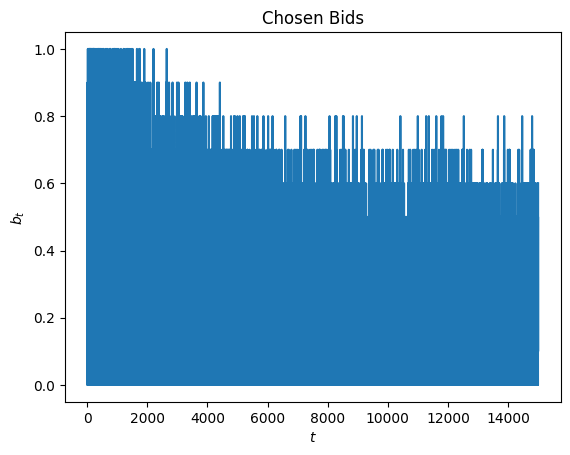

In [8]:
plt.plot(my_bids)
plt.xlabel('$t$')
plt.ylabel('$b_t$')
plt.title('Chosen Bids')
plt.show()

In [9]:
n_epochs = 1
all_regrets = []
all_payments = []
for i in range(n_epochs):
    agent = FFMultiplicativePacingAgent(bids_set = available_bids, 
                                        valuation=my_valuation,
                                        budget=Budget,
                                        T=n_users, 
                                        eta=eta)

    auction = FirstPriceAuction(np.ones(n_advertisers+1))
    utilities = np.array([])
    my_bids = np.array([])
    my_payments = np.array([])

    np.random.seed(i)
    for u in range(n_users):
        # interaction
        my_bid = agent.bid()
        bids = np.append(my_bid, other_bids[:, u].ravel())
        winners, payments_per_click = auction.round(bids=bids)
        my_win = int(winners==0)
        f_t, c_t = (my_valuation-m_t[u])*my_win, m_t[u]*my_win
        agent.update(f_t, c_t, m_t[u])
        # logging
        utilities = np.append(utilities, f_t)
        my_payments = np.append(my_payments, c_t)
    all_regrets.append(np.cumsum(expected_clairvoyant_utilities-utilities))
    all_payments.append(np.cumsum(my_payments))

avg_regret = np.array(all_regrets).mean(axis=0)
std_regret = np.array(all_regrets).std(axis=0)

avg_payments = np.array(all_payments).mean(axis=0)
std_payments = np.array(all_payments).std(axis=0)

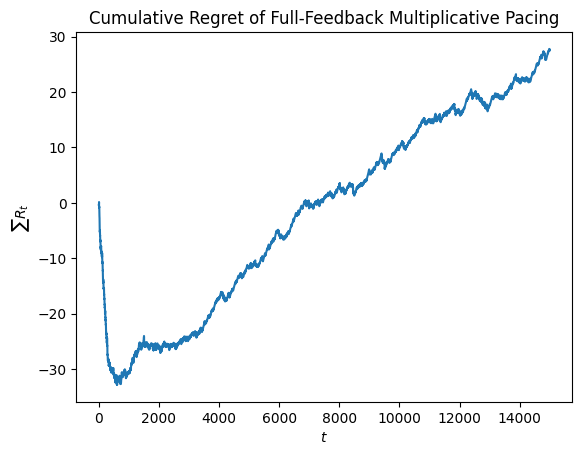

In [10]:
plt.plot(np.arange(n_users), avg_regret)
plt.fill_between(np.arange(n_users), avg_regret-std_regret, avg_regret+std_regret, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of Full-Feedback Multiplicative Pacing')
plt.show()

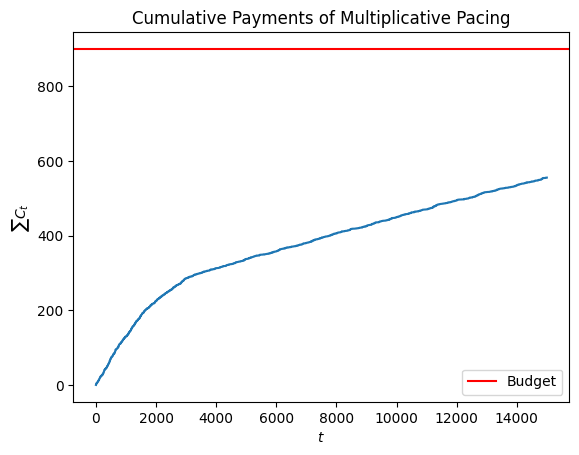

In [11]:
cumulative_payments = np.cumsum(my_payments)
plt.plot(cumulative_payments)
plt.xlabel('$t$')
plt.ylabel('$\sum C_t$')
plt.axhline(Budget, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Multiplicative Pacing')
plt.show()

# Putting all pieces together

In [15]:
#bidding parameters
days=200
n_users = 1000
n_advertisers = 3 # four advertisers
ctrs = np.ones(n_advertisers)
B = 100000
my_valuation=0.8
eta = 1/np.sqrt(n_users) # from theory
rho = B/n_users

# pricing parameters-----------------------------------------------------------------
epsilon = days**(-0.33)
K =  int(1/epsilon)
learning_rate = np.sqrt(np.log(K)/days)
prices = np.linspace(0,1,K) # 100 actions
cost = 0.25 #To be chosen

conversion_rates = []
random_steeps = np.random.uniform(1,5,days) #generates days parameters for the demand curve 1 for each day (ask if it could be more than one per day)
conversion_rates = [demand.generate_demand(0,1,steep) for steep in random_steeps]

reward_function = lambda price, n_sales: (price-cost)*n_sales


loss_profit_curve = []
for t in range(days):
    loss_profit_curve.append([(1-(price-cost)*conversion_rates[t](price)) for price in prices])
loss_profit_curve = np.array(loss_profit_curve)
summed_losses = np.sum(loss_profit_curve, axis=0)
best_price_index = np.argmin(summed_losses)
best_price = prices[best_price_index]

#logging-----------------------------------------------------------------------------
profits=np.array([])
clair_profits=np.array([])
bids_won_log=np.zeros(days)
clair_bids_won=np.zeros(days)
pricing_profit=np.zeros(days)
expected_clair_pricing_profit=np.zeros(days)


#agents,envs
bidding_agent=FFMultiplicativePacingAgent(np.linspace(0,1,11),my_valuation,B,n_users*days,eta)
auction = FirstPriceAuction(np.ones(n_advertisers+1))

pricing_env=PricingEnvironment(conversion_probability=conversion_rates, cost=cost, prices=prices)
pricing_agent=HedgeAgent(K, learning_rate)

#non-trivial scenario: competitors sample bids from a uniform with range varying over time
other_bids = np.array([generate_bids(n_advertisers, np.random.normal(0.5, 5), t) for t in range(n_users*days)]).T
m_t = other_bids.max(axis=0)


#TODO fix this , make it unique for all days!!!

available_bids = np.linspace(0,1,11)
win_probabilities = np.array([sum(b > m_t)/(n_users*days) for b in available_bids])
## Linear Program
c = -(my_valuation-available_bids)*win_probabilities
A_ub = [available_bids*win_probabilities]
b_ub = [rho]
A_eq = [np.ones(len(available_bids))]
b_eq = [1]
res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
gamma = res.x
expected_clairvoyant_utilities = [-res.fun for u in range(n_users*days)]
expected_clairvoyant_bids = [sum(available_bids*gamma*win_probabilities) for u in range(n_users*days)]
expectded_clairvoyant_payments = [sum(available_bids*gamma*win_probabilities) for u in range(n_users*days)]


clairvoyant_payments = []
for u in range(n_users*days):
    clairvoyant_bids = np.random.choice(available_bids, p=gamma)
    clairvoyant_payments.append(clairvoyant_bids*int(clairvoyant_bids >= m_t[u]))

    
for d in range(days):

    #--------------------- daily auctions------------------------------------------------------------------

    #bids won in the day
    bids_won=0
    #cost of the day
    tot_cost=0
    
    daily_bids = other_bids[:, d*n_users:(d+1)*n_users]

    for u in range(n_users):
        #choose bid
        my_bid = bidding_agent.bid()
        bids = np.append(my_bid, daily_bids[:, u].ravel())
        winners, payments_per_click = auction.round(bids=bids)
        my_win = int(winners==0)
        f_t, c_t = (my_valuation-m_t[u])*my_win, m_t[u]*my_win
        bids_won+=my_win
        tot_cost+=c_t
        #update bidding agent
        bidding_agent.update(f_t, c_t, m_t[u])
    bids_won_log[d]=bids_won


    #TODO apply a prob_rate of opening the advertisement---> n_customers =  bids_won*prob_rate

    #--------------------- daily pricing-------------------------------------------------------------------

    # Agent pricing
    price_i=pricing_agent.pull_arm()
    price = prices[price_i]
    if bids_won>0:
            l_t, r_t, d_t = pricing_env.round(price, bids_won, d)
            pricing_agent.update(l_t)
    else: 
        r_t=0
    pricing_profit[d]=r_t
    profits=np.append(profits,r_t-tot_cost)


    #calculate clairvoyant profit
    clair_num_daily=clairvoyant_payments[d*n_users:(d+1)*n_users]
    clair_num=np.count_nonzero(clair_num_daily)
    #cl,cr,cd=pricing_env.round(best_price,clair_num, d)

    clair_d_t = np.random.binomial(clair_num, conversion_rates[d](best_price))
    clair_r_t = (best_price - cost)*(clair_d_t)

    clair_cumpay=np.sum(clair_num_daily)
    clair_profits=np.append(clair_profits,clair_r_t-clair_cumpay)
    clair_bids_won[d]=clair_num

    #---------------------------------------------------------------------------------------------------------

profits=np.cumsum(profits)
clair_profits=np.cumsum(clair_profits)
bids_won_log=np.cumsum(bids_won_log)
clair_bids_won=np.cumsum(clair_bids_won)
pricing_profit=np.cumsum(pricing_profit)
expected_clair_pricing_profit=np.cumsum(expected_clair_pricing_profit)


In [ ]:
d=190
clair_num_daily=clairvoyant_payments
prova=bids_won_log[d]-bids_won_log[d-1]
np.count_nonzero(clair_num_daily),prova,np.sum(clair_num_daily)

(1000, 0.0, 87.49999999999999)

In [ ]:
np.sum(m_t),np.sum(clairvoyant_payments)

(706.8033135381813, 87.49999999999999)

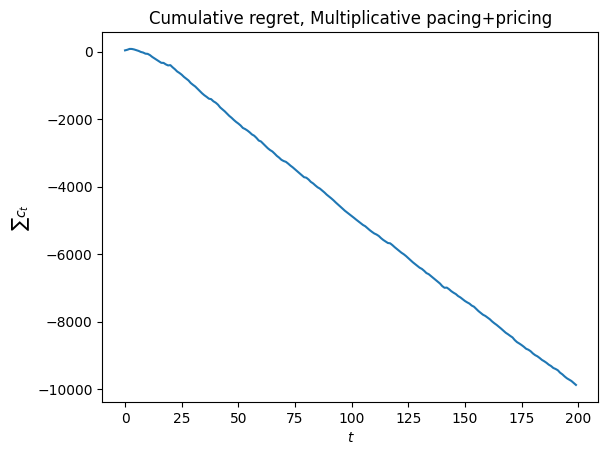

In [16]:
plt.plot(np.arange(days),clair_profits-profits)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.title('Cumulative regret, Multiplicative pacing+pricing')
plt.show()

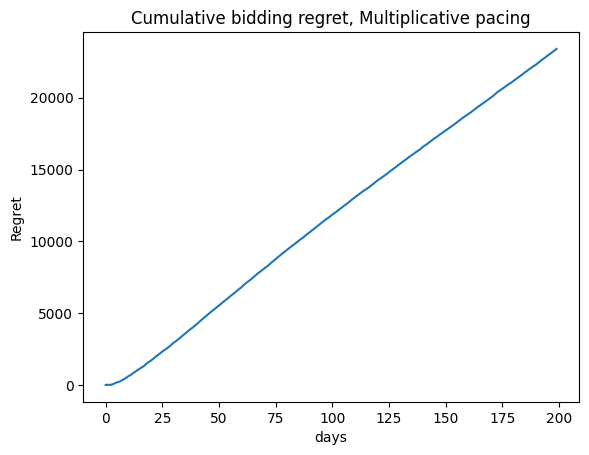

In [17]:
plt.plot(clair_bids_won-bids_won_log)
plt.xlabel('days')
plt.ylabel('Regret')
plt.title('Cumulative bidding regret, Multiplicative pacing')
plt.show()

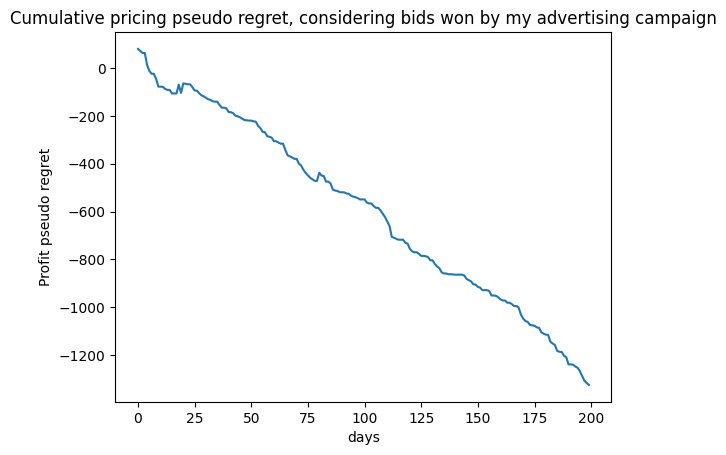

In [18]:
plt.plot(expected_clair_pricing_profit-pricing_profit)
plt.xlabel('days')
plt.ylabel('Profit pseudo regret')
plt.title('Cumulative pricing pseudo regret, considering bids won by my advertising campaign')
plt.show()

In [ ]:
bidding_agent.budget

38564.31209173116

In [ ]:
n_companies = 3
days = 10

bidding_agent=UCBlike_agent()
bidding_env=bidenv()
pricing_agent=GP_agent()
pricing_env=pricenv()
auction_env=auction(bidding_env, pricing_env)
for c in range(n_companies):
    for d in range(days):
        #choose price
        price=pricing_agent.ChoosePrice()

        #BIDDING
        bid = bidding_agent.ChooseBid(price)
        win_count = auction_env.round(bid)
        bidding_agent.update(bid,win_count)

        #PRICING
        d,r=auction_env.sell(price)
        pricing_agent.update(price,r/d)

SyntaxError: incomplete input (2836940658.py, line 16)

### This way we change bid value many times for the same price. Then each day we chamge the price p and we try with different prices